In [2]:
using Plots, DataFrames, StatsBase, Plots.PlotMeasures,
    LaTeXStrings, CSV, ProgressMeter, Dates, JLD, JSON, HTTP

DataDir = "../../Data/"
FigsDir = "../../Figs/"

include("Modules.jl")

theme(:dark)
Plots.default(titlefontsize=12, tickfontsize=10, labelfontsize=12, legendfontsize=9,
    rightmargin=5mm, bottommargin=15mm, topmargin=5mm, leftmargin=5mm,
    fontfamily="Computer Modern", frame=:box, label=nothing)

In [137]:
StartDate = DateTime(2020, 1, 1)
EndDate = DateTime(2022, 8, 1)
Markets = String[#="USD", =#"CNY", "EUR", "JPY", "GBP",
    "KRW", "INR", "CAD", "HKD", "AUD", "BRL", "CHF",
    "RUB", "MXN", "SGD", "IDR", "AED", "MYR", "PLN",
    "TRY", "NZD", "ZAR", "CZK", "ARS", "DKK", "NOK",
    "SEK", "NGN", "BHD", "LKR", "UAH"];
Symbols = String["ADA", "BCH", "BNB", "BTC", "DASH", "DOGE", "EOS",
    "ETC", "ETH", "LSK", "LTC", "NEO", "OMG",
    "TRX", "XEM", "XLM", "XMR", "XRP"];
ForExLoadDir = DataDir * "Raw-Data/AlphaVantage/ForEx-Daily/";
CryptoLoadDir = DataDir * "Raw-Data/AlphaVantage/Daily-Data/";

In [40]:
using BusinessDays

In [138]:
BTCToFIATDataFrames = Dict()
USDToFIATDataFrames = Dict()
for Market ∈ Markets
    df1 = sort(CSV.read(CryptoLoadDir * "BTC-$Market.csv", DataFrame))
    filter!(row -> isbday(:USSettlement, Date(row.timestamp)) &&
                       row.timestamp >= StartDate && row.timestamp <= EndDate, df1)

    df2 = sort(CSV.read(ForExLoadDir * "USD-$Market.csv", DataFrame))
    filter!(row -> isbday(:USSettlement, Date(row.timestamp)) &&
                       row.timestamp >= StartDate && row.timestamp <= EndDate, df2)
    
    filter!(row -> row.timestamp ∈ df1.timestamp, df2)
    filter!(row -> row.timestamp ∈ df2.timestamp, df1)

    BTCToFIATDataFrames[Market] = df1
    USDToFIATDataFrames[Market] = df2
end

In [100]:
DependenciesDict = Dict()
DependenciesList = Tuple[]
for Market ∈ Markets
    Correlation = cor(USDToFIATDataFrames[Market].open, BTCToFIATDataFrames[Market][!, "open ($Market)"])
    DependenciesDict[Market] = Correla
    push!(DependenciesList, (Market, Correlation))
end

In [114]:
bar(getindex.(DependenciesList, 1), getindex.(DependenciesList, 2), size=(1100, 600))
plot!(xticks=(0.5:29.5, getindex.(DependenciesList, 1)), xrotation = 30)

In [152]:
DependenciesDict = Dict()
SpanLen = 30
for Market ∈ Markets
    DataLen = size(BTCToFIATDataFrames[Market])[1]
    Correlations = [cor(USDToFIATDataFrames[Market].open[i:i+SpanLen],
        BTCToFIATDataFrames[Market][!, "open ($Market)"][i:i+SpanLen]) for i ∈ 1:DataLen-SpanLen]
    timestamp = USDToFIATDataFrames[Market].timestamp[1:DataLen-SpanLen]
    DependenciesDict[Market] = Dict("Correlations" => Correlations, "timestamp" => timestamp)
end

In [160]:
gr()

Plots.GRBackend()

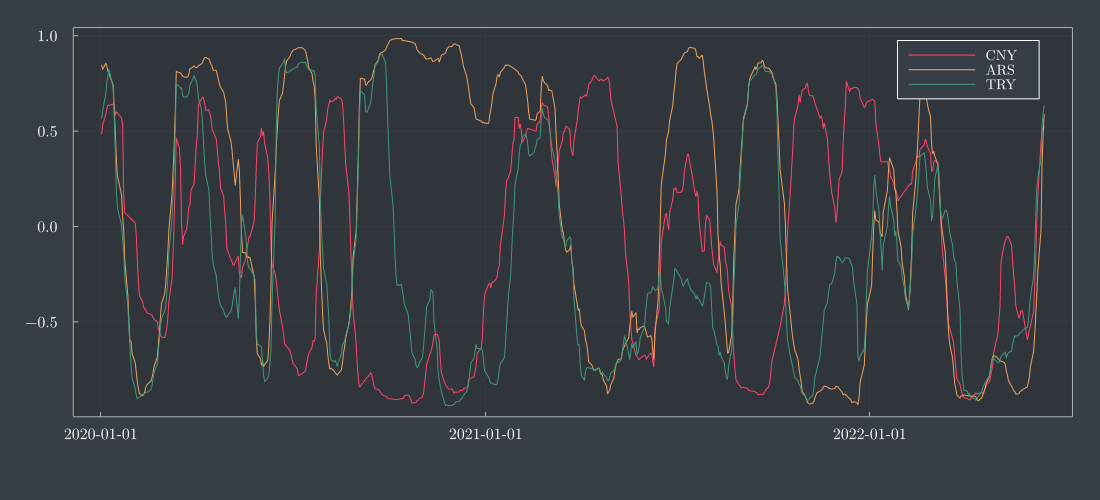

In [161]:
plot(DependenciesDict["CNY"]["timestamp"], DependenciesDict["CNY"]["Correlations"], label = "CNY")
plot!(DependenciesDict["ARS"]["timestamp"], DependenciesDict["ARS"]["Correlations"], label = "ARS")
plot!(DependenciesDict["TRY"]["timestamp"], DependenciesDict["TRY"]["Correlations"], label = "TRY")
plot!(size = (1100, 500), legend = :topright)

In [3]:
FIATCryptoData = Dict()
Markets = String["USD", "CNY", "EUR", "JPY", "GBP",
    "KRW", "INR", "CAD", "HKD", "AUD", "BRL", "CHF",
    "RUB", "MXN", "SGD", "IDR", "AED", "MYR", "PLN",
    "TRY", "NZD", "ZAR", "CZK", "ARS", "DKK", "NOK",
    "SEK", "NGN", "BHD", "LKR", "UAH"]
IDs = String["cardano", "bitcoin-cash", "binancecoin", "bitcoin",
    "dash", "dogecoin", "eos", "ethereum-classic",
    "ethereum", "lisk", "litecoin", "neo", "omisego",
    "tron", "nem", "stellar", "monero", "ripple"]
Symbols = String["ADA", "BCH", "BNB", "BTC", "DASH", "DOGE", "EOS",
    "ETC", "ETH", "LSK", "LTC", "NEO", "OMG",
    "TRX", "XEM", "XLM", "XMR", "XRP"]

Parameters = Dict(:Interval => "hourly", :DaysLimit => "90")
IDToSymbol = Dict([IDs[i] => Symbols[i] for i ∈ 1:length(IDs)])
p = Progress(length(Markets) * length(IDs))
for Market ∈ Markets
    for ID ∈ IDs
        next!(p)
        FIATCryptoData["$(IDToSymbol[ID])-$Market"] = DataHandler.GetCoinGeckoData(ID, Market; Parameters...)
        sleep(5)
    end
end

SaveDir = DataDir * "Raw-Data/CoinGecko/Max-Data-Intraday/"
save(SaveDir * "FIAT-Crypto-1Hour.jld", FIATCryptoData)

Progress: 100%|█████████████████████████████████████████| Time: 0:56:06mmmm


In [11]:
save(SaveDir * "FIAT-Crypto-1Hour-DataFrames.jld", CryptoFiatCorData)

In [18]:
CryptoFiatCorData["BTC"]["UAH"]

,Price,Date,TotalVolume,MarketCap,Returns
,Float64,DateTime,Float64,Float64,Float64
1,885160.0,2022-06-02T15:02:02.740,1.04195e12,1.68752e13,0.0
2,8.94022e5,2022-06-02T16:00:08.673,1.02493e12,1.70679e13,0.00996152
3,894426.0,2022-06-02T17:03:09.408,9.6106e11,1.70758e13,0.000452243
4,8.92589e5,2022-06-02T18:02:21.080,9.03452e11,1.70241e13,-0.00205566
5,8.9226e5,2022-06-02T19:02:11.197,8.77252e11,1.70082e13,-0.000368864
6,8.93855e5,2022-06-02T20:03:30.134,8.38579e11,1.70095e13,0.00178636
7,8.94574e5,2022-06-02T21:01:52.301,7.63551e11,1.70474e13,0.000803773
8,8.96461e5,2022-06-02T22:02:51.697,7.21942e11,1.70834e13,0.00210683
9,9.01184e5,2022-06-02T23:02:39.923,7.32753e11,1.71734e13,0.00525456


In [5]:
FIATDataFrames = LoadCoinGeckoDataFrame(FIATCryptoData)

Dict{Any, Any} with 558 entries:
  "ETH-MYR"  => 2161×5 DataFrame…
  "DOGE-AUD" => 2161×5 DataFrame…
  "XMR-BHD"  => 2162×5 DataFrame…
  "ETH-CHF"  => 2161×5 DataFrame…
  "XLM-PLN"  => 2161×5 DataFrame…
  "ADA-NGN"  => 2162×5 DataFrame…
  "XMR-SGD"  => 2162×5 DataFrame…
  "LTC-EUR"  => 2162×5 DataFrame…
  "XLM-INR"  => 2161×5 DataFrame…
  "LSK-AUD"  => 2162×5 DataFrame…
  "XRP-AED"  => 2162×5 DataFrame…
  "XMR-MYR"  => 2162×5 DataFrame…
  "XMR-SEK"  => 2162×5 DataFrame…
  "XEM-EUR"  => 2161×5 DataFrame…
  "ETC-BRL"  => 2164×5 DataFrame…
  "BNB-INR"  => 2161×5 DataFrame…
  "LTC-BRL"  => 2162×5 DataFrame…
  "XEM-CHF"  => 2161×5 DataFrame…
  "EOS-BRL"  => 2161×5 DataFrame…
  "XEM-MYR"  => 2161×5 DataFrame…
  "LSK-NZD"  => 2162×5 DataFrame…
  "LSK-JPY"  => 2162×5 DataFrame…
  "XEM-HKD"  => 2161×5 DataFrame…
  "BNB-GBP"  => 2161×5 DataFrame…
  "DOGE-AED" => 2161×5 DataFrame…
  ⋮          => ⋮

In [6]:
CryptoFiatCorData = Dict()
for Crypto ∈ Symbols
    MarketsData = Dict()
    for Market ∈ Markets
        MarketsData[Market] = dropmissing(FIATDataFrames["$Crypto-$Market"])
    end
    CryptoFiatCorData[Crypto] = MarketsData
end

Dict{Any, Any} with 18 entries:
  "BCH"  => Dict{Any, Any}("CZK"=>2162×5 DataFrame…
  "ETC"  => Dict{Any, Any}("CZK"=>2163×5 DataFrame…
  "LTC"  => Dict{Any, Any}("CZK"=>2162×5 DataFrame…
  "XMR"  => Dict{Any, Any}("CZK"=>2162×5 DataFrame…
  "XRP"  => Dict{Any, Any}("CZK"=>2162×5 DataFrame…
  "DOGE" => Dict{Any, Any}("CZK"=>2161×5 DataFrame…
  "ADA"  => Dict{Any, Any}("CZK"=>2162×5 DataFrame…
  "BTC"  => Dict{Any, Any}("CZK"=>2161×5 DataFrame…
  "LSK"  => Dict{Any, Any}("CZK"=>2162×5 DataFrame…
  "DASH" => Dict{Any, Any}("CZK"=>2163×5 DataFrame…
  "NEO"  => Dict{Any, Any}("CZK"=>2162×5 DataFrame…
  "EOS"  => Dict{Any, Any}("CZK"=>2162×5 DataFrame…
  "BNB"  => Dict{Any, Any}("CZK"=>2161×5 DataFrame…
  "ETH"  => Dict{Any, Any}("CZK"=>2161×5 DataFrame…
  "TRX"  => Dict{Any, Any}("CZK"=>2163×5 DataFrame…
  "XEM"  => Dict{Any, Any}("CZK"=>2161×5 DataFrame…
  "XLM"  => Dict{Any, Any}("CZK"=>2161×5 DataFrame…
  "OMG"  => Dict{Any, Any}("CZK"=>2161×5 DataFrame…

In [4]:
function LoadCoinGeckoDataFrame(Data)
    Markets = keys(Data)
    MarketsDataFrameDict = Dict()
    for Market ∈ Markets
        df = DataFrame()
        df.Price = replace(getindex.(Data[Market]["prices"], 2), nothing => missing)
        df.Date = unix2datetime.(getindex.(Data[Market]["prices"], 1) / 1000)
        df.TotalVolume = replace(getindex.(Data[Market]["total_volumes"], 2), nothing => missing)
        df.MarketCap = replace(getindex.(Data[Market]["market_caps"], 2), nothing => missing)
        df.Returns = [0.0; log.(df.Price[2:end]) .- log.(df.Price[1:end-1])]
        MarketsDataFrameDict[Market] = df
    end
    return MarketsDataFrameDict
end